In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import os
import datetime

from IPython.display import Image
from time import sleep
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from pandas import DataFrame, Series
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from amb_sdk.sdk import DarwinSdk

%matplotlib inline

# Cleaning Data

In [2]:
data = pd.read_csv("speed-dating_raw.csv")
x = ['gender', 'race', 'race_o', 'field']
columns = list(data)

# Deleting bins
for column in columns:
    if column not in x and data[str(column)].dtype.name == 'object':
        del data[str(column)]

# Deleting useless columns        
del data['has_null']
del data['wave']
del data['d_age']
del data['samerace']
del data['expected_happy_with_sd_people']
del data['expected_num_interested_in_me']
del data['expected_num_matches']
del data['like']
del data['guess_prob_liked']
del data['decision']
del data['decision_o']

# Replace age NA with mean
mean = round(data['age'].mean())
data['age'].fillna(mean, inplace = True)
mean = round(data['age_o'].mean())
data['age_o'].fillna(mean, inplace = True)

# Make sure difference in age is correct
data['age_d'] = (data['age'] - data['age_o'])
data['age_d_abs'] = data['age_d'].abs()

# Replace race NA with other
data['race'].fillna('other', inplace= True)
data['race_o'].fillna('other', inplace = True)

# Verifying that same_race is correct with replaced race
data['same_race'] = (data['race'] == data['race_o'])

# Replace NA with 0 for preferences
preferences = ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests']          
for pref in preferences:
    data[pref].fillna(0, inplace = True)

# Renaming column names
data.rename(columns = {'importance_same_race':'same_race_i',
                       'importance_same_religion': 'same_religion_i',
                       'pref_o_attractive':'attractive_o_i',
                       'pref_o_sincere':'sincere_o_i',
                       'pref_o_intelligence':'intelligence_o_i',
                       'pref_o_funny':'funny_o_i',
                       'pref_o_ambitious':'ambitious_o_i',
                       'pref_o_shared_interests':'shared_interests_o_i',
                       'attractive_important':'attractive_i',
                       'sincere_important': 'sincere_i',
                       'intellicence_important': 'intelligence_i',
                       'funny_important':'funny_i',
                       'ambtition_important':'ambitious_i',
                       'shared_interests_important':'shared_interests_i',
                       'ambition':'ambitious',
                       'sinsere_o': 'sincere_o',
                       'ambitous_o':'ambitious_o',
                       'ambition_partner':'ambitious_partner'}, inplace = True)

# Making sure that opposite's importance columns add up to 100
data['o_i'] = data['attractive_o_i'] + data['sincere_o_i'] + data['intelligence_o_i'] + data['funny_o_i'] + data['ambitious_o_i'] + data['shared_interests_o_i']
data['attractive_o_i'] = (data['attractive_o_i'] / data['o_i'])
data['sincere_o_i'] = (data['sincere_o_i'] / data['o_i'])
data['intelligence_o_i'] = (data['intelligence_o_i'] / data['o_i'])
data['funny_o_i'] = (data['funny_o_i'] / data['o_i'])
data['ambitious_o_i'] = (data['ambitious_o_i'] / data['o_i'])
data['shared_interests_o_i'] = (data['shared_interests_o_i'] / data['o_i'])

# Making sure that my importance columns add up to 100
data['i'] = data['attractive_i'] + data['sincere_i'] + data['intelligence_i'] + data['funny_i'] + data['ambitious_i'] + data['shared_interests_i']
data['attractive_i'] = (data['attractive_i'] / data['i'])
data['sincere_i'] = (data['sincere_i'] / data['i'])
data['intelligence_i'] = (data['intelligence_i'] / data['i'])
data['funny_i'] = (data['funny_i'] / data['i'])
data['ambitious_i'] = (data['ambitious_i'] / data['i'])
data['shared_interests_i'] = (data['shared_interests_i'] / data['i'])

del data['o_i']
del data['i']

# Filling in data that are empty
temp = ['attractive_o_i', 'sincere_o_i', 'intelligence_o_i', 'funny_o_i', 'ambitious_o_i', 'shared_interests_o_i', 'attractive_i', 'sincere_i', 'intelligence_i', 'funny_i', 'ambitious_i', 'shared_interests_i']          
for t in temp:
    data[t].fillna((1.0 / 6.0), inplace = True)

# Replacing same_race_i & same_religion_i with mean (importance)
mean = data['same_race_i'].mean()
data['same_race_i'].fillna(round(mean), inplace = True)

mean = data['same_religion_i'].mean()
data['same_religion_i'].fillna(round(mean), inplace = True)

# One Hot Encoding of categorical data
data = pd.concat([data, pd.get_dummies(data['gender'], prefix = 'gender')], axis = 1)
data = pd.concat([data, pd.get_dummies(data['race'], prefix = 'race')], axis = 1)
data = pd.concat([data, pd.get_dummies(data['race_o'], prefix = 'race_o')], axis = 1)
data = pd.concat([data, pd.get_dummies(data['field'], prefix = 'field')], axis = 1)

del data['gender']
del data['race']
del data['race_o']
del data['field']

# Label Encoding
le = LabelEncoder()
data['same_race'] = le.fit_transform(data['same_race'])

# Fill NA's with mean
mean = data['attractive_o'].mean()
data['attractive_o'].fillna(round(mean), inplace = True)
mean = data['sincere_o'].mean()
data['sincere_o'].fillna(round(mean), inplace = True)
mean = data['intelligence_o'].mean()
data['intelligence_o'].fillna(round(mean), inplace = True)
mean = data['funny_o'].mean()
data['funny_o'].fillna(round(mean), inplace = True)
mean = data['ambitious_o'].mean()
data['ambitious_o'].fillna(round(mean), inplace = True)
mean = data['shared_interests_o'].mean()
data['shared_interests_o'].fillna(round(mean), inplace = True)
mean = data['attractive'].mean()
data['attractive'].fillna(round(mean), inplace = True)
mean = data['sincere'].mean()
data['sincere'].fillna(round(mean), inplace = True)
mean = data['intelligence'].mean()
data['intelligence'].fillna(round(mean), inplace = True)
mean = data['funny'].mean()
data['funny'].fillna(round(mean), inplace = True)
mean = data['ambitious'].mean()
data['ambitious'].fillna(round(mean), inplace = True)
mean = data['attractive_partner'].mean()
data['attractive_partner'].fillna(round(mean), inplace = True)
mean = data['sincere_partner'].mean()
data['sincere_partner'].fillna(round(mean), inplace = True)
mean = data['intelligence_partner'].mean()
data['intelligence_partner'].fillna(round(mean), inplace = True)
mean = data['funny_partner'].mean()
data['funny_partner'].fillna(round(mean), inplace = True)
mean = data['ambitious_partner'].mean()
data['ambitious_partner'].fillna(round(mean), inplace = True)
mean = data['shared_interests_partner'].mean()
data['shared_interests_partner'].fillna(round(mean), inplace = True)
mean = data['met'].mean()
data['met'].fillna(round(mean), inplace = True)

# Delete rows with NA's for interests correlate
data = data.dropna(axis = 0, subset = ['interests_correlate'])

print(data.shape)
data.head()

(8220, 287)


age  age_o  same_race_i  same_religion_i  attractive_o_i  sincere_o_i  \
0  21.0   27.0          2.0              4.0            0.35         0.20   
1  21.0   22.0          2.0              4.0            0.60         0.00   
2  21.0   22.0          2.0              4.0            0.19         0.18   
3  21.0   23.0          2.0              4.0            0.30         0.05   
4  21.0   24.0          2.0              4.0            0.30         0.10   

   intelligence_o_i  funny_o_i  ambitious_o_i  shared_interests_o_i  \
0              0.20       0.20           0.00                  0.05   
1              0.00       0.40           0.00                  0.00   
2              0.19       0.18           0.14                  0.12   
3              0.15       0.40           0.05                  0.05   
4              0.20       0.10           0.10                  0.20   

                  ...                  field_tc [health ed]  \
0                 ...                                     0   
1                 ...                                     0   
2                 ...                                     0   
3                 ...                                     0   
4                 ...                                     0   

   field_teaching of english  field_tesol  field_theater  \
0                          0            0              0   
1                          0            0              0   
2                          0            0              0   
3                          0            0              0   
4                          0            0              0   

   field_theatre management & producing  field_theory  field_undergrad - gs  \
0                                     0             0                     0   
1                                     0             0                     0   
2                                     0             0                     0   
3                                     0             0                     0   
4                                     0             0                     0   

   field_urban planning  field_working  field_writing: literary nonfiction  
0                     0              0                                   0  
1                     0              0                                   0  
2                     0              0                                   0  
3                     0              0                                   0  
4                     0              0                                   0  

[5 rows x 287 columns]

# Feature Engineering

In [3]:
# Difference between opposite's and my importance
data['attractive_i_d'] = (data['attractive_i'] - data['attractive_o_i'])
data['sincere_i_d'] = (data['sincere_i'] - data['sincere_o_i'])
data['intelligence_i_d'] = (data['intelligence_i'] - data['intelligence_o_i'])
data['funny_i_d'] = (data['funny_i'] - data['funny_o_i'])
data['ambitious_i_d'] = (data['ambitious_i'] - data['ambitious_o_i'])
data['shared_interests_i_d'] = (data['shared_interests_i'] - data['shared_interests_o_i'])

# Absolute difference of importance
data['attractive_i_d_abs'] = data['attractive_i_d'].abs()
data['sincere_i_d_abs'] = data['sincere_i_d'].abs()
data['intelligence_i_d_abs'] = data['intelligence_i_d'].abs()
data['funny_i_d_abs'] = data['funny_i_d'].abs()
data['ambitious_i_d_abs'] = data['ambitious_i_d'].abs()
data['shared_interests_i_d_abs'] = data['shared_interests_i_d'].abs()

# Difference between opposite's and my rating of me
data['attractive_d'] = (data['attractive'] - data['attractive_o'])
data['sincere_d'] = (data['sincere'] - data['sincere_o'])
data['intelligence_d'] = (data['intelligence'] - data['intelligence_o'])
data['funny_d'] = (data['funny'] - data['funny_o'])
data['ambitious_d'] = (data['ambitious'] - data['ambitious_o'])
data['shared_interests_d'] = (data['shared_interests_partner'] - data['shared_interests_o'])

# Absolute difference of rating
data['attractive_d_abs'] = data['attractive_d'].abs()
data['sincere_d_abs'] = data['sincere_d'].abs()
data['intelligence_d_abs'] = data['intelligence_d'].abs()
data['funny_d_abs'] = data['funny_d'].abs()
data['ambitious_d_abs'] = data['ambitious_d'].abs()
data['shared_interests_d_abs'] = data['shared_interests_d'].abs()

# Changing from [1-10] scale to percentage for opposite's rating
data['o'] = data['attractive_o'] + data['sincere_o'] + data['intelligence_o'] + data['funny_o'] + data['ambitious_o'] + data['shared_interests_o']
data['attractive_o_n'] = (data['attractive_o'] / data['o'])
data['sincere_o_n'] = (data['sincere_o'] / data['o'])
data['intelligence_o_n'] = (data['intelligence_o'] / data['o'])
data['funny_o_n'] = (data['funny_o'] / data['o'])
data['ambitious_o_n'] = (data['ambitious_o'] / data['o'])
data['shared_interests_o_n'] = (data['shared_interests_o'] / data['o'])

# Changing from [1-10] scale to percentage for my rating of opposite
data['p'] = data['attractive_partner'] + data['sincere_partner'] + data['intelligence_partner'] + data['funny_partner'] + data['ambitious_partner'] + data['shared_interests_partner']
data['attractive_p_n'] = (data['attractive_partner'] / data['p'])
data['sincere_p_n'] = (data['sincere_partner'] / data['p'])
data['intelligence_p_n'] = (data['intelligence_partner'] / data['p'])
data['funny_p_n'] = (data['funny_partner'] / data['p'])
data['ambitious_p_n'] = (data['ambitious_partner'] / data['p'])
data['shared_interests_p_n'] = (data['shared_interests_partner'] / data['p'])

del data['o']
del data['p']

# Filling in blanks with 0
preferences = ['attractive_o_n', 'sincere_o_n', 'intelligence_o_n', 'funny_o_n', 'ambitious_o_n', 'shared_interests_o_n', 'attractive_p_n', 'sincere_p_n', 'intelligence_p_n', 'funny_p_n', 'ambitious_p_n', 'shared_interests_p_n']
for pref in preferences:
    data[pref].fillna(0, inplace = True)

# Difference of rating percentage
data['d'] = data['attractive_d_abs'] + data['sincere_d_abs'] + data['intelligence_d_abs'] + data['funny_d_abs'] + data['ambitious_d_abs'] + data['shared_interests_d_abs']
data['attractive_d_n'] = (data['attractive_d'] / data['d'])
data['sincere_d_n'] = (data['sincere_d'] / data['d'])
data['intelligence_d_n'] = (data['intelligence_d'] / data['d'])
data['funny_d_n'] = (data['funny_d'] / data['d'])
data['ambitious_d_n'] = (data['ambitious_d'] / data['d'])
data['shared_interests_d_n'] = (data['shared_interests_d'] / data['d'])

del data['d']

# Absolute difference of rating percentage
data['attractive_d_n_abs'] = data['attractive_d_n'].abs()
data['sincere_d_n_abs'] = data['sincere_d_n'].abs()
data['intelligence_d_n_abs'] = data['intelligence_d_n'].abs()
data['funny_d_n_abs'] = data['funny_d_n'].abs()
data['ambitious_d_n_abs'] = data['ambitious_d_n'].abs()
data['shared_interests_d_n_abs'] = data['shared_interests_d_n'].abs()

# Difference between opposite's importance and their rating of me
data['attractive_oi_o_d_n'] = (data['attractive_o_i'] - data['attractive_o_n'])
data['sincere_oi_o_d_n'] = (data['sincere_o_i'] - data['sincere_o_n'])
data['intelligence_oi_o_d_n'] = (data['intelligence_o_i'] - data['intelligence_o_n'])
data['funny_oi_o_d_n'] = (data['funny_o_i'] - data['funny_o_n'])
data['ambitious_oi_o_d_n'] = (data['ambitious_o_i'] - data['ambitious_o_n'])
data['shared_interests_oi_o_d_n'] = (data['shared_interests_o_i'] - data['shared_interests_o_n'])

# Absolute difference of opposite's importance and their rating of me
data['attractive_oi_o_d_n_abs'] = data['attractive_oi_o_d_n'].abs()
data['sincere_oi_o_d_n_abs'] = data['sincere_oi_o_d_n'].abs()
data['intelligence_oi_o_d_n_abs'] = data['intelligence_oi_o_d_n'].abs()
data['funny_oi_o_d_n_abs'] = data['funny_oi_o_d_n'].abs()
data['ambitious_oi_o_d_n_abs'] = data['ambitious_oi_o_d_n'].abs()
data['shared_interests_oi_o_d_n_abs'] = data['shared_interests_oi_o_d_n'].abs()

# Difference between my importance and my rating of opposite
data['attractive_i_p_d_n'] = (data['attractive_i'] - data['attractive_p_n'])
data['sincere_i_p_d_n'] = (data['sincere_i'] - data['sincere_p_n'])
data['intelligence_i_p_d_n'] = (data['intelligence_i'] - data['intelligence_p_n'])
data['funny_i_p_d_n'] = (data['funny_i'] - data['funny_p_n'])
data['ambitious_i_p_d_n'] = (data['ambitious_i'] - data['ambitious_p_n'])
data['shared_interests_i_p_d_n'] = (data['shared_interests_i'] - data['shared_interests_p_n'])

# Absolute difference of my importance and my rating of opposite
data['attractive_i_p_d_n_abs'] = data['attractive_i_p_d_n'].abs()
data['sincere_i_p_d_n_abs'] = data['sincere_i_p_d_n'].abs()
data['intelligence_i_p_d_n_abs'] = data['intelligence_i_p_d_n'].abs()
data['funny_i_p_d_n_abs'] = data['funny_i_p_d_n'].abs()
data['ambitious_i_p_d_n_abs'] = data['ambitious_i_p_d_n'].abs()
data['shared_interests_i_p_d_n_abs'] = data['shared_interests_i_p_d_n'].abs()

# Changing from [1-10] scale to percentage for activities
data['a'] = data['sports'] + data['tvsports'] + data['exercise'] + data['dining'] + data['museums'] + data['art'] + data['hiking'] + data['gaming'] + data['clubbing'] + data['reading'] + data['tv'] + data['theater'] + data['movies'] + data['concerts'] + data['music'] + data['shopping'] + data['yoga']
data['sports_n'] = (data['sports'] / data['a']) 
data['tvsports_n'] = (data['tvsports'] / data['a']) 
data['exercise_n'] = (data['exercise'] / data['a']) 
data['dining_n'] = (data['dining'] / data['a']) 
data['museums_n'] = (data['museums'] / data['a']) 
data['art_n'] = (data['art'] / data['a']) 
data['hiking_n'] = (data['hiking'] / data['a']) 
data['gaming_n'] = (data['gaming'] / data['a']) 
data['clubbing_n'] = (data['clubbing'] / data['a']) 
data['reading_n'] = (data['reading'] / data['a']) 
data['tv_n'] = (data['tv'] / data['a']) 
data['theater_n'] = (data['theater'] / data['a']) 
data['movies_n'] = (data['movies'] / data['a']) 
data['concerts_n'] = (data['concerts'] / data['a']) 
data['music_n'] = (data['music'] / data['a']) 
data['shopping_n'] = (data['shopping'] / data['a']) 
data['yoga_n'] = (data['yoga'] / data['a']) 

del data['a']

# Data Exploration

In [4]:
data.describe()

age        age_o  same_race_i  same_religion_i  attractive_o_i  \
count  8220.000000  8220.000000  8220.000000      8220.000000     8220.000000   
mean     26.352433    26.358151     3.786861         3.658394        0.224587   
std       3.560063     3.554994     2.847048         2.808630        0.125650   
min      18.000000    18.000000     0.000000         1.000000        0.000000   
25%      24.000000    24.000000     1.000000         1.000000        0.150000   
50%      26.000000    26.000000     3.000000         3.000000        0.200000   
75%      28.000000    28.000000     6.000000         6.000000        0.250000   
max      55.000000    55.000000    10.000000        10.000000        1.000000   

       sincere_o_i  intelligence_o_i    funny_o_i  ambitious_o_i  \
count  8220.000000       8220.000000  8220.000000    8220.000000   
mean      0.173892          0.202748     0.174212       0.106632   
std       0.070048          0.067890     0.060907       0.060157   
min       0.000000          0.000000     0.000000       0.000000   
25%       0.150000          0.173900     0.150000       0.050000   
50%       0.181818          0.200000     0.180000       0.100000   
75%       0.200000          0.231244     0.200000       0.150000   
max       0.600000          0.500000     0.500000       0.358108   

       shared_interests_o_i     ...          gaming_n   clubbing_n  \
count           8220.000000     ...       8220.000000  8220.000000   
mean               0.117929     ...          0.036166     0.053805   
std                0.063851     ...          0.023600     0.022790   
min                0.000000     ...          0.000000     0.000000   
25%                0.085100     ...          0.015595     0.038835   
50%                0.108678     ...          0.032609     0.057851   
75%                0.160000     ...          0.052632     0.070707   
max                0.300000     ...          0.127273     0.129032   

         reading_n         tv_n    theater_n     movies_n   concerts_n  \
count  8220.000000  8220.000000  8220.000000  8220.000000  8220.000000   
mean      0.073338     0.049716     0.063273     0.074976     0.063683   
std       0.021737     0.023288     0.018743     0.015831     0.017971   
min       0.009804     0.007752     0.000000     0.000000     0.000000   
25%       0.061947     0.033333     0.052083     0.066667     0.053763   
50%       0.073394     0.050847     0.065934     0.075472     0.065421   
75%       0.085470     0.065574     0.075758     0.085470     0.075758   
max       0.164557     0.125000     0.111111     0.121951     0.128205   

           music_n   shopping_n       yoga_n  
count  8220.000000  8220.000000  8220.000000  
mean      0.074192     0.052228     0.039977  
std       0.016225     0.022787     0.024072  
min       0.008772     0.007407     0.000000  
25%       0.064103     0.035211     0.019608  
50%       0.075188     0.053571     0.036036  
75%       0.084112     0.068376     0.057692  
max       0.128205     0.149254     0.138889  

[8 rows x 376 columns]

match
0    6870
1    1350
dtype: int64


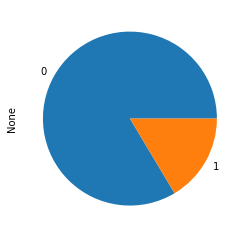

In [5]:
# Pie chart of match
groups = data.groupby('match')
print(groups.size())
groups.size().plot.pie()

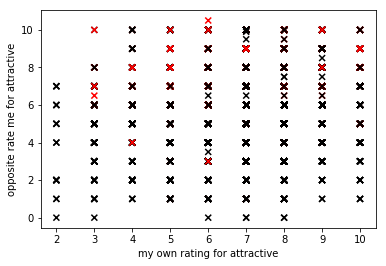

In [6]:
# Scatter plot of attractiveness (my own rating vs opposite rate me)
colors = {1:'red', 0:'black'}
plt.scatter(data['attractive'], 
           data['attractive_o'], 
           c = data['match'].apply(lambda x: colors[x]),
           marker = 'x')
plt.xlabel('my own rating for attractive')
plt.ylabel('opposite rate me for attractive')

plt.show()

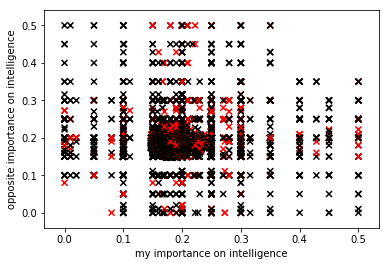

In [7]:
# Scatter plot of importance of intelligence (me vs opposite)
colors = {1:'red', 0:'black'}
plt.scatter(data['intelligence_i'], 
           data['intelligence_o_i'], 
           c = data['match'].apply(lambda x: colors[x]),
           marker = 'x')
plt.xlabel('my importance on intelligence')
plt.ylabel('opposite importance on intelligence')

plt.show()

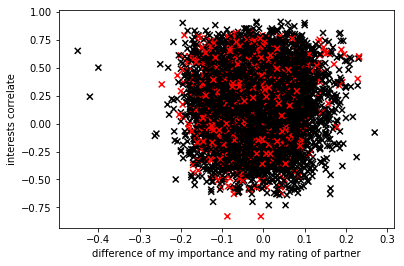

In [8]:
# Scatter plot of difference of my importance and my rating of partner vs interests correlate
colors = {1:'red', 0:'black'}
plt.scatter(data['shared_interests_i_p_d_n'], 
           data['interests_correlate'], 
           c = data['match'].apply(lambda x: colors[x]),
           marker = 'x')
plt.xlabel('difference of my importance and my rating of partner')
plt.ylabel('interests correlate')

plt.show()

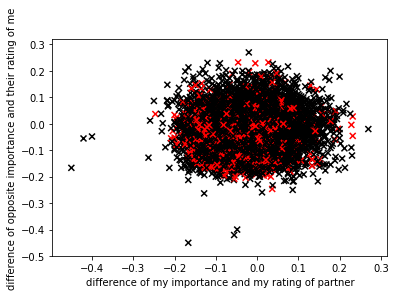

In [9]:
# Scatter plot of difference of my importance and my rating of partner vs difference of my partner's importance and their rating of me
colors = {1:'red', 0:'black'}
plt.scatter(data['shared_interests_i_p_d_n'], 
           data['shared_interests_oi_o_d_n'], 
           c = data['match'].apply(lambda x: colors[x]),
           marker = 'x')
plt.xlabel('difference of my importance and my rating of partner')
plt.ylabel('difference of opposite importance and their rating of me')

plt.show()

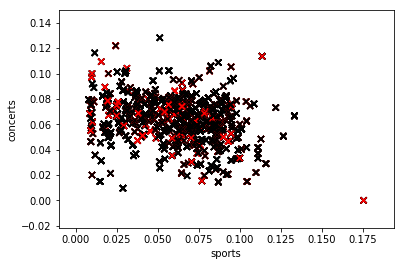

In [10]:
# Scatter plot of sports vs concerts
colors = {1:'red', 0:'black'}
plt.scatter(data['sports_n'], 
           data['concerts_n'], 
           c = data['match'].apply(lambda x: colors[x]),
           marker = 'x')
plt.xlabel('sports')
plt.ylabel('concerts')

plt.show()

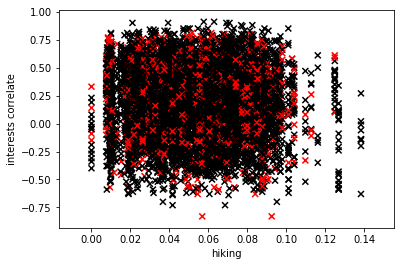

In [11]:
# Scatter plot of hiking vs interests correlate
colors = {1:'red', 0:'black'}
plt.scatter(data['hiking_n'], 
           data['interests_correlate'], 
           c = data['match'].apply(lambda x: colors[x]),
           marker = 'x')
plt.xlabel('hiking')
plt.ylabel('interests correlate')

plt.show()

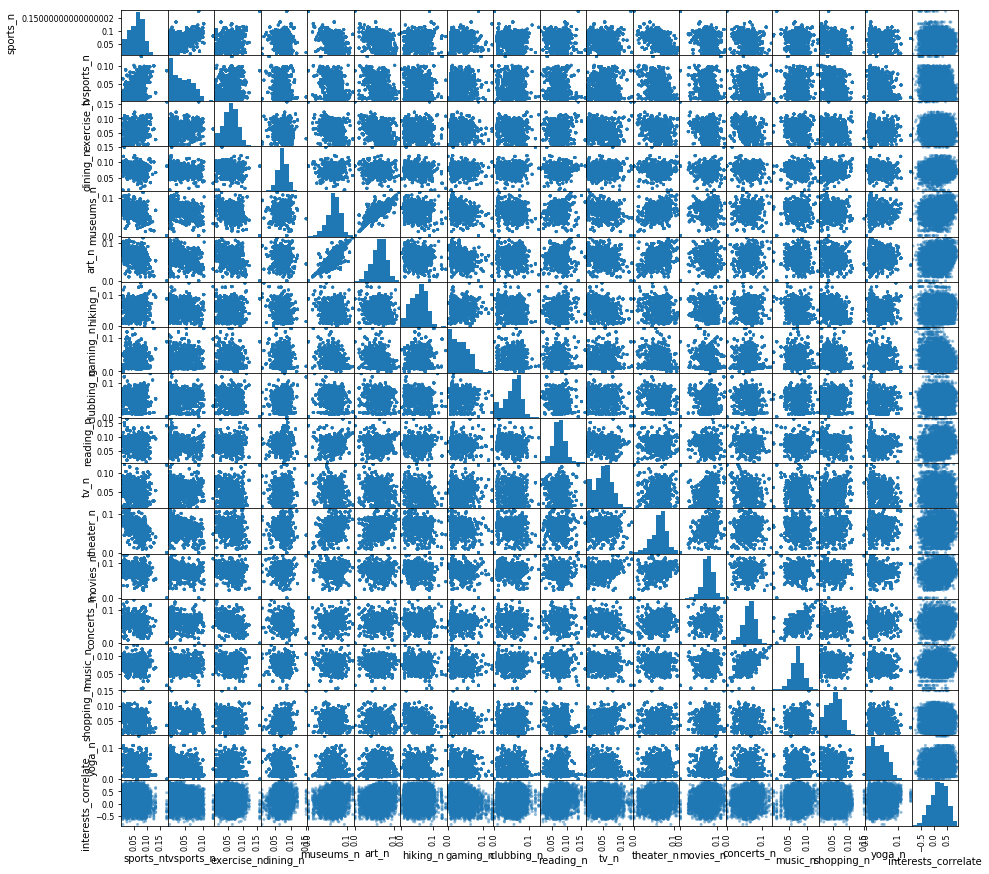

In [12]:
# Scatter matrix of activities and interests correlate
pd.plotting.scatter_matrix(data[['sports_n','tvsports_n','exercise_n','dining_n','museums_n','art_n','hiking_n','gaming_n','clubbing_n','reading_n','tv_n','theater_n','movies_n','concerts_n','music_n','shopping_n','yoga_n','interests_correlate']], figsize = (15,15))
plt.show()

# SMOTE

In [13]:
data_Y = data['match']
data_X = data.drop(['match'], axis = 1)

sm = SMOTE(sampling_strategy = 'minority', random_state = 11)
smote_X, smote_Y = sm.fit_sample(data_X, data_Y)

print(smote_X.shape)
print(smote_Y.shape)
smote_X = DataFrame(smote_X, columns = data_X.columns)
smote_Y = Series(smote_Y, name = 'match')
data = pd.concat([smote_X, smote_Y], axis = 1)
data.head()

data.to_csv('Speed_Dating_Clean_SMOTE.csv', index = False)

# Create train and test data for Darwin (SMOTE)
data_Y = data['match']
data_X = data.drop(['match'], axis = 1)

train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size = 0.20, random_state = 11)
train_data = pd.concat([train_X, train_Y], axis = 1)
train_data.to_csv('Speed_Dating_Clean_SMOTE_train.csv', index = False)
test_data = pd.concat([test_X, test_Y], axis = 1)
test_data.to_csv('Speed_Dating_Clean_SMOTE_test.csv', index = False) 

(13740, 375)
(13740,)


# Decision Tree

In [14]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = DecisionTreeClassifier(random_state = 11)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 80.08560272276455

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 80.96797671033478
Classification report (test):
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      1376
           1       0.79      0.85      0.82      1372

   micro avg       0.81      0.81      0.81      2748
   macro avg       0.81      0.81      0.81      2748
weighted avg       0.81      0.81      0.81      2748

Wall time: 31.1 s


In [15]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = DecisionTreeClassifier(random_state = 11)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Set parameters
params = {"clf__criterion" : ['gini', 'entropy'],
          "clf__max_depth": [20, 25, 30, 35],
          "clf__max_features": ['sqrt', 'log2'],
          "clf__min_samples_leaf": [3, 5, 7]
         }

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'clf__criterion': 'entropy', 'clf__max_depth': 25, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 3}

Accuracy (model): 78.67540029112081

Accuracy (train): 96.53384279475983
Classification report (train):
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      5494
           1       0.97      0.96      0.97      5498

   micro avg       0.97      0.97      0.97     10992
   macro avg       0.97      0.97      0.97     10992
weighted avg       0.97      0.97      0.97     10992

Accuracy (test): 78.82096069868996
Classification report (test):
               precision    recall  f1-score   support

           0       0.80      0.76      0.78      1376
           1       0.77      0.81      0.79      1372

   micro avg       0.79      0.79      0.79      2748
   macro avg       0.79      0.79      0.79      2748
weighted avg       0.79      0.79      0.79      2748

Wall time: 4min 3s


# Random Forest

In [16]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = RandomForestClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 90.99342370110698

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 92.13973799126637
Classification report (test):
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      1376
           1       0.92      0.92      0.92      1372

   micro avg       0.92      0.92      0.92      2748
   macro avg       0.92      0.92      0.92      2748
weighted avg       0.92      0.92      0.92      2748

Wall time: 1min 41s


In [17]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = RandomForestClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Set parameters
params = {"clf__criterion" : ['gini', 'entropy'],
          "clf__max_depth": [20, 25, 30, 35],
          "clf__max_features": ['sqrt', 'log2'],
          "clf__min_samples_leaf": [3, 5, 7]
         }

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'clf__criterion': 'entropy', 'clf__max_depth': 35, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 3}

Accuracy (model): 90.2019650655022

Accuracy (train): 99.79985443959242
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 91.30276564774381
Classification report (test):
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1376
           1       0.91      0.92      0.91      1372

   micro avg       0.91      0.91      0.91      2748
   macro avg       0.91      0.91      0.91      2748
weighted avg       0.91      0.91      0.91      2748

Wall time: 58min 10s


# AdaBoost

In [18]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = AdaBoostClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 81.61421151654838

Accuracy (train): 85.10735080058224
Classification report (train):
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      5494
           1       0.84      0.87      0.85      5498

   micro avg       0.85      0.85      0.85     10992
   macro avg       0.85      0.85      0.85     10992
weighted avg       0.85      0.85      0.85     10992

Accuracy (test): 80.49490538573508
Classification report (test):
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      1376
           1       0.80      0.82      0.81      1372

   micro avg       0.80      0.80      0.80      2748
   macro avg       0.81      0.80      0.80      2748
weighted avg       0.81      0.80      0.80      2748

Wall time: 3min 10s


# Gradient Boosting

In [19]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = GradientBoostingClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 83.24257192128182

Accuracy (train): 86.98144104803494
Classification report (train):
               precision    recall  f1-score   support

           0       0.89      0.84      0.87      5494
           1       0.85      0.89      0.87      5498

   micro avg       0.87      0.87      0.87     10992
   macro avg       0.87      0.87      0.87     10992
weighted avg       0.87      0.87      0.87     10992

Accuracy (test): 81.76855895196506
Classification report (test):
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1376
           1       0.80      0.85      0.82      1372

   micro avg       0.82      0.82      0.82      2748
   macro avg       0.82      0.82      0.82      2748
weighted avg       0.82      0.82      0.82      2748

Wall time: 2min 7s


In [20]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = GradientBoostingClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Set parameters
params = {"clf__max_depth": [20, 25, 30, 35],
          "clf__max_features": ['sqrt', 'log2'],
          "clf__min_samples_leaf": [3, 5, 7]
         }

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'clf__max_depth': 30, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 5}

Accuracy (model): 93.22234352256187

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 93.70451237263464
Classification report (test):
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      1376
           1       0.93      0.94      0.94      1372

   micro avg       0.94      0.94      0.94      2748
   macro avg       0.94      0.94      0.94      2748
weighted avg       0.94      0.94      0.94      2748

Wall time: 43min 5s


# Extreme Gradient Boosting

In [21]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = XGBClassifier(seed = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 83.2334892690961

Accuracy (train): 86.64483260553129
Classification report (train):
               precision    recall  f1-score   support

           0       0.89      0.84      0.86      5494
           1       0.85      0.90      0.87      5498

   micro avg       0.87      0.87      0.87     10992
   macro avg       0.87      0.87      0.87     10992
weighted avg       0.87      0.87      0.87     10992

Accuracy (test): 81.51382823871907
Classification report (test):
               precision    recall  f1-score   support

           0       0.84      0.77      0.81      1376
           1       0.79      0.86      0.82      1372

   micro avg       0.82      0.82      0.82      2748
   macro avg       0.82      0.82      0.81      2748
weighted avg       0.82      0.82      0.81      2748

Wall time: 2min 29s


In [22]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = XGBClassifier(seed = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Set parameters
params = {"clf__max_depth": [20, 25, 30, 35]}

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'clf__max_depth': 35}

Accuracy (model): 90.74781659388647

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 91.0844250363901
Classification report (test):
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      1376
           1       0.88      0.95      0.91      1372

   micro avg       0.91      0.91      0.91      2748
   macro avg       0.91      0.91      0.91      2748
weighted avg       0.91      0.91      0.91      2748

Wall time: 34min 4s


# KNN

In [23]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
knn = KNeighborsClassifier()

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('knn', knn)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 79.98557376136914

Accuracy (train): 87.627365356623
Classification report (train):
               precision    recall  f1-score   support

           0       0.97      0.78      0.86      5494
           1       0.81      0.97      0.89      5498

   micro avg       0.88      0.88      0.88     10992
   macro avg       0.89      0.88      0.88     10992
weighted avg       0.89      0.88      0.88     10992

Accuracy (test): 82.53275109170306
Classification report (test):
               precision    recall  f1-score   support

           0       0.93      0.71      0.80      1376
           1       0.76      0.94      0.84      1372

   micro avg       0.83      0.83      0.83      2748
   macro avg       0.84      0.83      0.82      2748
weighted avg       0.85      0.83      0.82      2748

Wall time: 3min 16s


In [24]:
%%time

scaler = MinMaxScaler()
pca = PCA(0.95, random_state = 11)
knn = KNeighborsClassifier()

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('knn', knn)])

# Set parameters
params = {'knn__n_neighbors': [3, 5, 7, 9]}

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'knn__n_neighbors': 3}

Accuracy (model): 82.15065502183407

Accuracy (train): 92.09425036390103
Classification report (train):
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      5494
           1       0.87      0.99      0.93      5498

   micro avg       0.92      0.92      0.92     10992
   macro avg       0.93      0.92      0.92     10992
weighted avg       0.93      0.92      0.92     10992

Accuracy (test): 84.27947598253274
Classification report (test):
               precision    recall  f1-score   support

           0       0.96      0.71      0.82      1376
           1       0.77      0.97      0.86      1372

   micro avg       0.84      0.84      0.84      2748
   macro avg       0.87      0.84      0.84      2748
weighted avg       0.87      0.84      0.84      2748

Wall time: 8min 36s


# SVM

In [25]:
%%time

scaler = StandardScaler()

# Creating svc. Here we use the default instead of linear as mentioned on the piazza post. 
svc_clf = SVC(random_state = 11)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('svc', svc_clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 88.05500869926242

Accuracy (train): 92.94941775836972
Classification report (train):
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      5494
           1       0.91      0.95      0.93      5498

   micro avg       0.93      0.93      0.93     10992
   macro avg       0.93      0.93      0.93     10992
weighted avg       0.93      0.93      0.93     10992

Accuracy (test): 88.68267831149927
Classification report (test):
               precision    recall  f1-score   support

           0       0.91      0.86      0.88      1376
           1       0.87      0.92      0.89      1372

   micro avg       0.89      0.89      0.89      2748
   macro avg       0.89      0.89      0.89      2748
weighted avg       0.89      0.89      0.89      2748

Wall time: 4min 15s


# Naive Bayes

In [26]:
%%time

# Create NB clf and fit it
clf_rf = GaussianNB()

# CV on train
scores = cross_val_score(clf_rf, train_X, train_Y, cv = 10)

# Fit the model
clf_rf.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", clf_rf.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, clf_rf.predict(train_X)))
print("Accuracy (test):", clf_rf.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, clf_rf.predict(test_X)))

Accuracy (model): 58.03354594890566

Accuracy (train): 59.006550218340614
Classification report (train):
               precision    recall  f1-score   support

           0       0.86      0.21      0.34      5494
           1       0.55      0.97      0.70      5498

   micro avg       0.59      0.59      0.59     10992
   macro avg       0.71      0.59      0.52     10992
weighted avg       0.71      0.59      0.52     10992

Accuracy (test): 58.406113537117896
Classification report (test):
               precision    recall  f1-score   support

           0       0.83      0.21      0.34      1376
           1       0.55      0.96      0.70      1372

   micro avg       0.58      0.58      0.58      2748
   macro avg       0.69      0.58      0.52      2748
weighted avg       0.69      0.58      0.52      2748

Wall time: 1.86 s


# Neural Networks

In [27]:
%%time

scaler = StandardScaler()
clf = MLPClassifier(random_state = 11)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 92.9767681825782

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 93.70451237263464
Classification report (test):
               precision    recall  f1-score   support

           0       0.98      0.90      0.93      1376
           1       0.90      0.98      0.94      1372

   micro avg       0.94      0.94      0.94      2748
   macro avg       0.94      0.94      0.94      2748
weighted avg       0.94      0.94      0.94      2748

Wall time: 54.7 s


In [28]:
%%time

scaler = StandardScaler()
clf = MLPClassifier(random_state = 11)

# Create pipeline
pipe = Pipeline(steps = [('scaler', scaler), ('clf', clf)])

# Set parameters
param_grid = {
    'clf__hidden_layer_sizes': [(50,), (60,), (70,), (80,), (90,), (100,)],
    'clf__activation': ['identity', 'logistic', 'tanh', 'relu']
}

# Find best parameters
grid_search = GridSearchCV(pipe, param_grid, cv = 5)

# Fit model and print best hyperparameters
grid_search.fit(train_X, train_Y)
print(grid_search.best_params_)

# Print results
print("\nAccuracy (model):", grid_search.best_score_ * 100)
print("\nAccuracy (train):", grid_search.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, grid_search.predict(train_X)))
print("Accuracy (test):", grid_search.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, grid_search.predict(test_X)))

{'clf__activation': 'relu', 'clf__hidden_layer_sizes': (70,)}

Accuracy (model): 93.04039301310044

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 93.95924308588064
Classification report (test):
               precision    recall  f1-score   support

           0       0.98      0.90      0.94      1376
           1       0.91      0.98      0.94      1372

   micro avg       0.94      0.94      0.94      2748
   macro avg       0.94      0.94      0.94      2748
weighted avg       0.94      0.94      0.94      2748

Wall time: 17min 49s


# Darwin (SMOTE)

In [2]:
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('EMMIECHNG@UTEXAS.EDU', 'QMCZgepW6u')

if not status:
    print(msg)

In [3]:
dataset_train = 'Speed_Dating_Clean_SMOTE_train.csv'
dataset_test = 'Speed_Dating_Clean_SMOTE_test.csv'

**Remove datasets**

In [4]:
# Remove previously uploaded datasets to not run into errors
if ds.lookup_dataset_name("Speed_Dating_Clean_SMOTE_train.csv")[0]:
    ds.delete_dataset("Speed_Dating_Clean_SMOTE_train.csv")
    
if ds.lookup_dataset_name("Speed_Dating_Clean_SMOTE_test.csv")[0]:
    ds.delete_dataset("Speed_Dating_Clean_SMOTE_test.csv")

**Upload datasets**

In [5]:
# Upload train dataset to Darwin
data_SMOTE_train = pd.read_csv("Speed_Dating_Clean_SMOTE_train.csv")
status, dataset = ds.upload_dataset("Speed_Dating_Clean_SMOTE_train.csv")

if not status:
    print(dataset)

In [6]:
# Upload test dataset to Darwin
data_SMOTE_test = pd.read_csv("Speed_Dating_Clean_SMOTE_test.csv")
status, dataset = ds.upload_dataset("Speed_Dating_Clean_SMOTE_test.csv")

if not status:
    print(dataset)

In [7]:
ds.lookup_dataset()

(True,
 [{'name': 'Speed_Dating_Clean_SMOTE_train.csv',
   'mbytes': 30.262596130371094,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-22T11:12:13.881803',
   'categorical': None,
   'sequential': None,
   'imbalanced': None},
  {'name': 'Speed_Dating_Clean_SMOTE_test.csv',
   'mbytes': 7.55277156829834,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-22T11:12:47.964370',
   'categorical': None,
   'sequential': None,
   'imbalanced': None}])

**Clean datasets**

In [8]:
# Clean train dataset on Darwin
target = "match"
status, job_id = ds.clean_data(dataset_train, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T11:12:49.244585', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['95bb2700919742f89741f8cba38e0f7b'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T11:12:49.244585', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['95bb2700919742f89741f8cba38e0f7b'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'starttime': '2019-04-22T11:12:49.244585', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['95bb2700919742f89741f8cba38e0f7b'], 'model_name': None, 'job_error': None}
{'status': 'Requested', 'startt

In [9]:
# Clean test dataset on Darwin
target = "match"
status, job_id = ds.clean_data(dataset_test, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T11:14:36.04432', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['d876b41069134d5a956c0d79503cf51f'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-22T11:14:36.04432', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['d876b41069134d5a956c0d79503cf51f'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:14:36.04432', 'endtime': '2019-04-22T11:15:03.994981', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['d876b41069134d5a956c0d79503cf51f'], 'model_name': None, 'job_error': ''}


**Create model**

In [10]:
# Create Darwin model
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
model = target + "_model" + ts
status, job_id = ds.create_model(dataset_names = dataset_train,
                                 model_name = model,
                                 max_train_time = '00:10')

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T11:15:07.461203', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-22T11:15:07.461203', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T11:15:07.461203', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T11:15:07.461203', 'endtime': None, 'p

{'status': 'Running', 'starttime': '2019-04-22T11:15:07.461203', 'endtime': None, 'percent_complete': 25, 'job_type': 'TrainModel', 'loss': 0.3900963068008423, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T11:15:07.461203', 'endtime': None, 'percent_complete': 25, 'job_type': 'TrainModel', 'loss': 0.3900963068008423, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T11:15:07.461203', 'endtime': None, 'percent_complete': 25, 'job_type': 'TrainModel', 'loss': 0.3900963068008423, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04

In [11]:
# Extra training for Darwin model
status, job_id = ds.resume_training_model(dataset_names = dataset_train, 
                                         model_name = model,
                                         max_train_time = '00:10')

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T11:25:12.080623', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.3900963068008423, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-22T11:25:12.080623', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.3900963068008423, 'generations': 5, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T11:25:12.080623', 'endtime': None, 'percent_complete': 2, 'job_type': 'UpdateModel', 'loss': 0.3900963068008423, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '201

{'status': 'Running', 'starttime': '2019-04-22T11:25:12.080623', 'endtime': None, 'percent_complete': 10, 'job_type': 'UpdateModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T11:25:12.080623', 'endtime': None, 'percent_complete': 10, 'job_type': 'UpdateModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T11:25:12.080623', 'endtime': None, 'percent_complete': 10, 'job_type': 'UpdateModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Running', 'starttime': '2019

# Best model decided by Darwin

**Analyze model**

In [12]:
# Analyze Darwin model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-22T11:35:17.0012', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': None, 'artifact_names': ['7bd3fd20fe014ff8b195eca39305320b'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:35:17.0012', 'endtime': '2019-04-22T11:35:21.272969', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': None, 'artifact_names': ['7bd3fd20fe014ff8b195eca39305320b'], 'model_name': 'match_model20190423001504', 'job_error': ''}


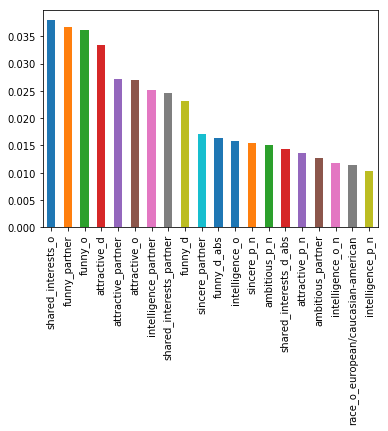

In [13]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [14]:
status, artifact = ds.run_model(dataset_train, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-22T11:35:35.300034', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['6c1fe73717f145f2bcc6541b2792d987'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:35:35.300034', 'endtime': '2019-04-22T11:35:39.809758', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['6c1fe73717f145f2bcc6541b2792d987'], 'model_name': 'match_model20190423001504', 'job_error': ''}

    match    prob_0        prob_1
0      1  0.000003  9.999967e-01
1      1  0.000052  9.999478e-01
2      0  0.999999  7.398000e-07
3      1  0.000023  9.999774e-01
4      0  0.999985  1.468370e-05


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992



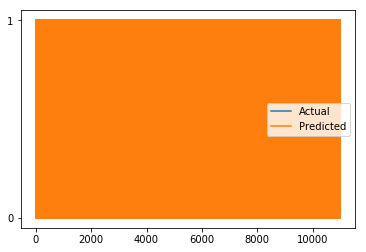

In [15]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [16]:
status, artifact = ds.run_model(dataset_test, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-22T11:35:54.525946', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['572083557e294403abbe9775a1d1621a'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:35:54.525946', 'endtime': '2019-04-22T11:35:56.434128', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['572083557e294403abbe9775a1d1621a'], 'model_name': 'match_model20190423001504', 'job_error': ''}

    match    prob_0    prob_1
0      0  1.000000  0.000000
1      0  0.997848  0.002152
2      1  0.002437  0.997563
3      0  0.911268  0.088732
4      0  0.849077  0.150923


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.63      0.82      0.71      1376
           1       0.74      0.51      0.61      1372

   micro avg       0.67      0.67      0.67      2748
   macro avg       0.68      0.67      0.66      2748
weighted avg       0.68      0.67      0.66      2748



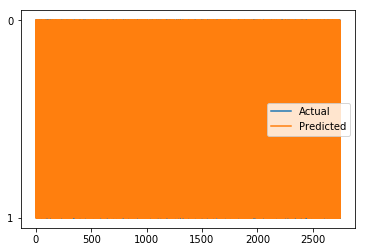

In [17]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

**Model Darwin used**

In [18]:
status, model_type = ds.lookup_model_name(model)
print(model_type)

{'type': 'Supervised', 'updated_at': '2019-04-22T11:35:32.949046', 'trained_on': ['Speed_Dating_Clean_SMOTE_train.csv'], 'loss': 0.3900963068008423, 'generations': 8, 'parameters': {'train_time': '00:10', 'target': 'match', 'recurrent': False, 'max_unique_values': 50, 'max_int_uniques': 15, 'impute': 'mean', 'big_data': False}, 'description': {'best_genome': [{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 671}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 2}}}], 'recurrent': False, 'genome_type': 'DeepNet'}, 'train_time_seconds': 628, 'algorithm': None, 'running_job_id': None}


In [19]:
ds.display_population(model)

(True,
 {'population': {'model_types': {'DeepNeuralNetwork': {'model_description': [{'layer 1': {'type': 'LinearGene',
        'parameters': {'activation': 'relu', 'numunits': 671}}},
      {'layer 2': {'type': 'LinearGene',
        'parameters': {'activation': 'relu', 'numunits': 2}}}],
     'loss_function': 'CrossEntropy',
     'fitness': 1.9999999234248123},
    'RandomForest': {'model_description': {'type': 'RandomForestClassifier',
      'parameters': {'bootstrap': True,
       'criterion': 'entropy',
       'max_depth': 7,
       'max_features': 0.4269319814753295,
       'max_leaf_nodes': None,
       'min_impurity_decrease': 0.0,
       'min_samples_leaf': 6,
       'min_samples_split': 10,
       'n_jobs': -1,
       'min_weight_fraction_leaf': 0.0,
       'n_estimators': 392}},
     'loss_function': 'CrossEntropy',
     'fitness': 1.879879430838899},
    'GradientBoosted': {'model_description': {'type': 'XGBClassifier',
      'parameters': {'base_score': 0.5,
       'colsampl

# DeepNeuralNetwork

**Analyze DeepNeuralNetwork model**

In [20]:
# Analyze Darwin DeepNeuralNetwork model
status, artifact = ds.analyze_model(model, model_type = 'DeepNeuralNetwork')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-22T11:36:13.451067', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': None, 'artifact_names': ['9c0a60a92fc24a1eb1fdac8906c85096'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:36:13.451067', 'endtime': '2019-04-22T11:36:17.733674', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': None, 'artifact_names': ['9c0a60a92fc24a1eb1fdac8906c85096'], 'model_name': 'match_model20190423001504', 'job_error': ''}


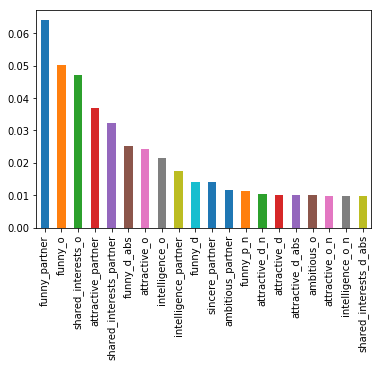

In [21]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [22]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'DeepNeuralNetwork')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-22T11:36:31.38152', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['2411901790eb452ca93a6223aea1be18'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:36:31.38152', 'endtime': '2019-04-22T11:36:35.080746', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['2411901790eb452ca93a6223aea1be18'], 'model_name': 'match_model20190423001504', 'job_error': ''}

    match    prob_0        prob_1
0      1  0.000003  9.999967e-01
1      1  0.000052  9.999478e-01
2      0  0.999999  7.398000e-07
3      1  0.000023  9.999774e-01
4      0  0.999985  1.468370e-05


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992



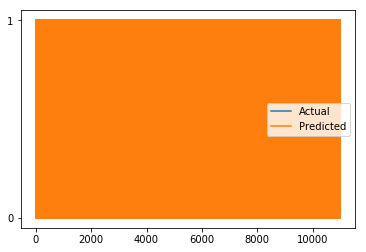

In [23]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [24]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'DeepNeuralNetwork')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-22T11:36:50.487744', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['5efa057d548049488afb1361729d6b6d'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:36:50.487744', 'endtime': '2019-04-22T11:36:52.900508', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['5efa057d548049488afb1361729d6b6d'], 'model_name': 'match_model20190423001504', 'job_error': ''}

    match    prob_0    prob_1
0      0  1.000000  0.000000
1      0  0.997848  0.002152
2      1  0.002437  0.997563
3      0  0.911268  0.088732
4      0  0.849077  0.150923


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.63      0.82      0.71      1376
           1       0.74      0.51      0.61      1372

   micro avg       0.67      0.67      0.67      2748
   macro avg       0.68      0.67      0.66      2748
weighted avg       0.68      0.67      0.66      2748



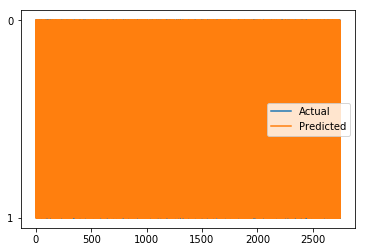

In [25]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

# RandomForest

**Analyze RandomForest model**

In [26]:
# Analyze Darwin RandomForest model
status, artifact = ds.analyze_model(model, model_type = 'RandomForest')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-22T11:37:08.764863', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': None, 'artifact_names': ['9a9e800dae3246e290b1474d40ddaf67'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:37:08.764863', 'endtime': '2019-04-22T11:37:15.295343', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': None, 'artifact_names': ['9a9e800dae3246e290b1474d40ddaf67'], 'model_name': 'match_model20190423001504', 'job_error': ''}


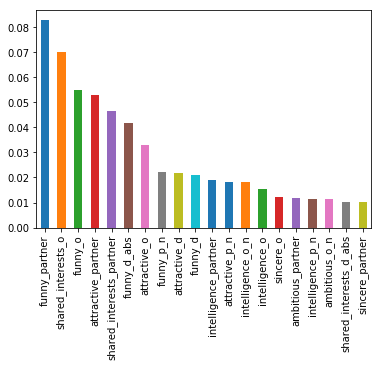

In [27]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [28]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'RandomForest')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-22T11:37:26.718876', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['25db027900184dfabd0c1c71a6c93d08'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:37:26.718876', 'endtime': '2019-04-22T11:37:32.90328', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['25db027900184dfabd0c1c71a6c93d08'], 'model_name': 'match_model20190423001504', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.157483  0.842517
1      1  0.195402  0.804598
2      1  0.271942  0.728058
3      1  0.414061  0.585939
4      1  0.470954  0.529046


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.92      0.88      0.90      5494
           1       0.89      0.92      0.90      5498

   micro avg       0.90      0.90      0.90     10992
   macro avg       0.90      0.90      0.90     10992
weighted avg       0.90      0.90      0.90     10992



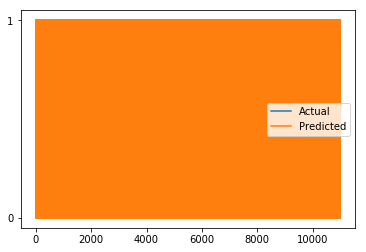

In [29]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [30]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'RandomForest')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-22T11:37:45.597586', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['72f36fbf0b9745f790eddaebb17884d1'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:37:45.597586', 'endtime': '2019-04-22T11:37:48.961693', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['72f36fbf0b9745f790eddaebb17884d1'], 'model_name': 'match_model20190423001504', 'job_error': ''}

    match    prob_0    prob_1
0      0  0.908279  0.091721
1      1  0.057126  0.942874
2      1  0.260901  0.739099
3      1  0.060900  0.939100
4      0  0.750380  0.249620


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.91      0.65      0.76      1376
           1       0.73      0.93      0.82      1372

   micro avg       0.79      0.79      0.79      2748
   macro avg       0.82      0.79      0.79      2748
weighted avg       0.82      0.79      0.79      2748



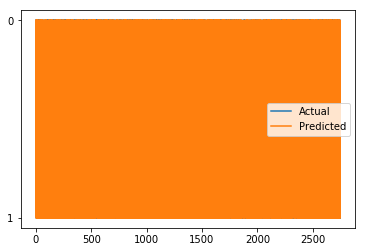

In [31]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

# GradientBoosted

**Analyze GradientBoosted model**

In [32]:
# Analyze Darwin GradientBoosted model
status, artifact = ds.analyze_model(model, model_type = 'GradientBoosted')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-22T11:38:03.833514', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': None, 'artifact_names': ['0943323f2f364f48a0bca3d34b4312e7'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:38:03.833514', 'endtime': '2019-04-22T11:38:08.540983', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': None, 'artifact_names': ['0943323f2f364f48a0bca3d34b4312e7'], 'model_name': 'match_model20190423001504', 'job_error': ''}


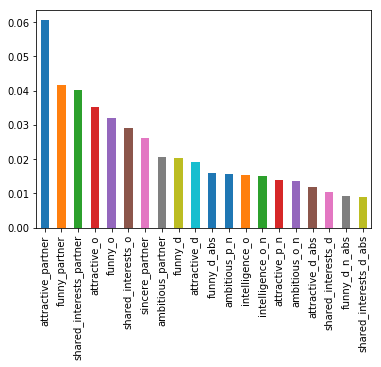

In [33]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [34]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'GradientBoosted')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-22T11:38:21.769668', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['0def0b130c3c4d87b7fbc421503f464e'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:38:21.769668', 'endtime': '2019-04-22T11:38:25.192073', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['0def0b130c3c4d87b7fbc421503f464e'], 'model_name': 'match_model20190423001504', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.001253  0.998747
1      1  0.000442  0.999558
2      0  0.991268  0.008732
3      1  0.253154  0.746846
4      0  0.988753  0.011247


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.98      0.99      0.98      5494
           1       0.99      0.98      0.98      5498

   micro avg       0.98      0.98      0.98     10992
   macro avg       0.98      0.98      0.98     10992
weighted avg       0.98      0.98      0.98     10992



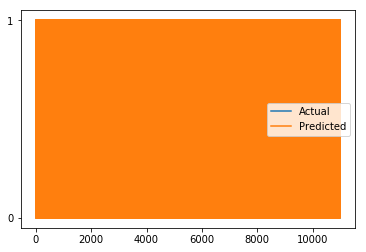

In [35]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [36]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'GradientBoosted')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-22T11:38:40.686853', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['b991388c5b2b40babec34a118c016484'], 'model_name': 'match_model20190423001504', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-22T11:38:40.686853', 'endtime': '2019-04-22T11:38:42.503293', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.3900963068008423, 'generations': 8, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['b991388c5b2b40babec34a118c016484'], 'model_name': 'match_model20190423001504', 'job_error': ''}

    match    prob_0    prob_1
0      0  0.989572  0.010428
1      1  0.001542  0.998458
2      1  0.001947  0.998053
3      1  0.000002  0.999998
4      0  0.879072  0.120928


**Create plots comparing predictions with actual target**


               precision    recall  f1-score   support

           0       0.95      0.28      0.43      1376
           1       0.58      0.98      0.73      1372

   micro avg       0.63      0.63      0.63      2748
   macro avg       0.76      0.63      0.58      2748
weighted avg       0.76      0.63      0.58      2748



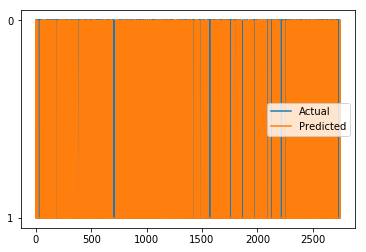

In [37]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

# Darwin's hyperparameter

**Looking at the model accuracy with Darwin's selected hyperparameters**

In [29]:
%%time

# DeepNeuralNetwork
scaler = StandardScaler()
clf = MLPClassifier(random_state = 11, hidden_layer_sizes = (671, 2), activation = 'relu')

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 93.26807034138052

Accuracy (train): 95.36026200873363
Classification report (train):
               precision    recall  f1-score   support

           0       0.98      0.93      0.95      5494
           1       0.93      0.98      0.95      5498

   micro avg       0.95      0.95      0.95     10992
   macro avg       0.95      0.95      0.95     10992
weighted avg       0.95      0.95      0.95     10992

Accuracy (test): 90.72052401746726
Classification report (test):
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      1376
           1       0.87      0.96      0.91      1372

   micro avg       0.91      0.91      0.91      2748
   macro avg       0.91      0.91      0.91      2748
weighted avg       0.91      0.91      0.91      2748

Wall time: 12min 14s


In [30]:
%%time

# RandomForest
scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = RandomForestClassifier(random_state = 11, bootstrap = True, criterion = 'entropy',
                             max_depth = 7, max_features = 0.4269319814753295, max_leaf_nodes = None,
                             min_impurity_decrease = 0.0, min_samples_leaf = 6, min_samples_split = 10,
                             n_jobs = -1, min_weight_fraction_leaf = 0.0, n_estimators = 392)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 80.0127222922204

Accuracy (train): 82.31441048034934
Classification report (train):
               precision    recall  f1-score   support

           0       0.86      0.77      0.81      5494
           1       0.79      0.88      0.83      5498

   micro avg       0.82      0.82      0.82     10992
   macro avg       0.83      0.82      0.82     10992
weighted avg       0.83      0.82      0.82     10992

Accuracy (test): 78.82096069868996
Classification report (test):
               precision    recall  f1-score   support

           0       0.82      0.74      0.78      1376
           1       0.76      0.84      0.80      1372

   micro avg       0.79      0.79      0.79      2748
   macro avg       0.79      0.79      0.79      2748
weighted avg       0.79      0.79      0.79      2748

Wall time: 12min 57s


In [31]:
%%time

# GradientBoosted
scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = XGBClassifier(seed = 11, base_score = 0.5, colsample_bylevel = 1,
                    colsample_bytree = 1, gamma = 0, learning_rate = 0.2737388404262005,
                    max_delta_step = 0, max_depth = 5, min_child_weight = 9,
                    n_estimators = 479, n_jobs = -1, reg_alpha = 0,
                    reg_lambda = 1, scale_pos_weight = 1, subsample = 0.7182506900415471)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# CV on train
scores = cross_val_score(pipe, train_X, train_Y, cv = 5)

# Fit the model
pipe.fit(train_X, train_Y)

# Print results
print("Accuracy (model):", scores.mean() * 100)
print("\nAccuracy (train):", pipe.score(train_X, train_Y) * 100)
print("Classification report (train):\n", classification_report(train_Y, pipe.predict(train_X)))
print("Accuracy (test):", pipe.score(test_X, test_Y) * 100)
print("Classification report (test):\n", classification_report(test_Y, pipe.predict(test_X)))

Accuracy (model): 92.02166444245486

Accuracy (train): 100.0
Classification report (train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5494
           1       1.00      1.00      1.00      5498

   micro avg       1.00      1.00      1.00     10992
   macro avg       1.00      1.00      1.00     10992
weighted avg       1.00      1.00      1.00     10992

Accuracy (test): 92.10334788937409
Classification report (test):
               precision    recall  f1-score   support

           0       0.95      0.89      0.92      1376
           1       0.90      0.95      0.92      1372

   micro avg       0.92      0.92      0.92      2748
   macro avg       0.92      0.92      0.92      2748
weighted avg       0.92      0.92      0.92      2748

Wall time: 14min 26s
